<style>
  h1 {
    font-size: 60px;
  }
</style>

<h1>RL PROJECT - DICE GAME</h1>

by Liam Phan 

_Student Number: 19-320-563_

**Table of contents**<a id='toc0_'></a>    
- 1. [The Game](#toc1_)    
  - 1.1. [FlowChart](#toc1_1_)    
  - 1.2. [The Dices](#toc1_2_)    
- 2. [The Task](#toc2_)    
  - 2.1. [Considering the game as a Markov decision process, identify the state space S, the action space A, and the reward set R.](#toc2_1_)    
  - 2.2. [Implement a Python class that represents the game as a reinforcement learning task. The class should contain all the information about the game state, and should provide a “step” method that takes an action as input and returns the reward and next state, as well as a “reset” method that resets the game to its initial state](#toc2_2_)    
  - 2.3. [Using dynamic programming, compute the value functions under the following policies. Explain the results and represent them graphically.](#toc2_3_)    
  - 2.4. [Find the optimal policy using dynamic programming. Represent the action-value function under the optimal policy graphically. Explain the results and compare them to those of the previous task.](#toc2_4_)    
- 3. [The Bonus](#toc3_)    
  - 3.1. [“R1”: The player always rolls a single dice](#toc3_1_)    
  - 3.2. [“R2”: The player always rolls both dice.](#toc3_2_)    
  - 3.3. [“RR”: If the player’s score is strictly smaller than 20, they roll either one or two dice with equal probability. Otherwise, they choose one of the three bet-multiplicators uniformly at random](#toc3_3_)    
  - 3.4. ["Optimal": Play R2 until 21, then R1 from 22 until 25 and Bet on the Dealer outcomes with Multiplicator of 1 from 26 to 27, Bet on the Dealer with Multiplicator of 3 from 28 until the end of the round.](#toc3_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<p style="page-break-after:always;"></p>

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from fractions import Fraction

<p style="page-break-after:always;"></p>

# 1. <a id='toc1_'></a>[The Game](#toc0_)

In this project, we consider the following “Dice Game”. The objective of the game is to make money by
outscoring the dealer or by rolling doubles. Each round, the player starts with a score of zero. Since this
is an episodic task, discounting is not necessary.

Each turn, the player has to choose between rolling their dice, or betting money on the dealer’s roll. If
they decide to roll themselves, they can either roll one or two dice (simultaneously), which costs them
CHF 1 for one dice, and CHF 2 for two dice. The number(s) shown by the dice are added to the player’s
score. If the player rolls a double (i.e., two dice showing the same numbers), they get an immediate
bonus payout of CHF 10, independent of the rest of the game or their score. If the player reaches a
score of 31 or more, they lose the round and have to pay CHF 10.

If the player chooses to bet on the dealer’s roll, they have to specify a bet-multiplicator of 1, 2, or 3. The
dealer then rolls their dice and the player is paid/has to pay according to the formula
(“Player Score” −“Dealer Dice Result”) ·“Bet-Multiplicator”,
and the round is over

The player has two identical dice, showing the numbers {1,2,3,4,5,6}. The dealer has one dice,
showing the numbers {25,26,27,28,29,30}. All three dice are weighted, such that their highest
number has twice the probability of each of the smaller numbers.

<p style="page-break-after:always;"></p>

## 1.1. <a id='toc1_1_'></a>[FlowChart](#toc0_)

<p align="center">
    <img src="IMAGES/RL PROJECT FLOWCHART QUICK.png" width="800" align="center">
</p>

To get a better sense of the Dice Game logic, I created this <a href="RL PROJECT FLOWCHART.pdf">FLOWCHART</a>


<p style="page-break-after:always;"></p>

## 1.2. <a id='toc1_2_'></a>[The Dices](#toc0_)

#### Player

---

The Player Dices have the following setup:

    P(D = 1) = p
    P(D = 2) = p
    P(D = 3) = p
    P(D = 4) = p
    P(D = 5) = p
    P(D = 6) = 2p

Therefore, since the Universe is equal to 1 by definition, p should sum to 1 as well:

    p + p + p + p + p + 2p = 1 

    6p + p = 1

    7p = 1

    p = 1/7

The Player Dices have the following properties:

    P(D = 1) = 1/7
    P(D = 2) = 1/7
    P(D = 3) = 1/7
    P(D = 4) = 1/7
    P(D = 5) = 1/7
    P(D = 6) = 2/7

#### Dealer

---

The Dealer Dice have the following setup:

    P(D = 25) = p
    P(D = 26) = p
    P(D = 27) = p
    P(D = 28) = p
    P(D = 29) = p
    P(D = 30) = 2p

Therefore, since the Universe is equal to 1 by definition, p should sum to 1 as well:

    p + p + p + p + p + 2p = 1 

    5p + 2p = 1

    7p = 1

    p = 1/7

The Dealer Dice  have the following properties:

    P(D = 25) = 1/7
    P(D = 26) = 1/7
    P(D = 27) = 1/7
    P(D = 28) = 1/7
    P(D = 29) = 1/7
    P(D = 30) = 2/7

---

<p style="page-break-after:always;"></p>

# 2. <a id='toc2_'></a>[The Task](#toc0_)

Throughout, the state space should have (at most) one terminal state

## 2.1. <a id='toc2_1_'></a>[Considering the game as a Markov decision process, identify the state space S, the action space A, and the reward set R.](#toc0_)

---

- State Space (S) is defined by the Player Score after a **TURN**, and thus can range from 0 to 31


   $S = \{0, 1, ..., 31\} $ 


- The Action Space (A) is defined by the set of possible Actions the player can choose at each **TURN**, and thus can be the following:
   
        1. Roll one dice or 
        2. two dices simulteanously
        3. Bet on the Dealer Roll (Specify 1,2,3 in the Bet-Multiplicator, which is then an action for each)
        

- The Reward Set (R) can be seen as the reward for each actions, therefore the player can:

    For Rolling the Dice:
        
        1. Gain 8CHF if 2 Dices roll have the same value (10CHF - the initial cost of 2 dices (2CHF))
        2. Lose 1CHF if 1 Dice roll (not payout, except the initial cost of 1 dice (1CHF))
        3. Lose -10CHF if the Player Score reach 31 and above 
    
    For Betting on Dealer Dice:
    
        4. (Player Score - Dealer Dice Result) * Bet-Multiplicator CHF, 
        can be gain or loss depending on the Dealer Dice value

---

<p style="page-break-after:always;"></p>

## 2.2. <a id='toc2_2_'></a>[Implement a Python class that represents the game as a reinforcement learning task. The class should contain all the information about the game state, and should provide a “step” method that takes an action as input and returns the reward and next state, as well as a “reset” method that resets the game to its initial state](#toc0_)

### Dice Game Class

In [5]:
class DiceGame: 

    def __init__(self):
        self.state = 0

    def reset(self):
        self.state = 0
        print("\nDice Game Reset !", "Score:", self.state)

    def step(self, action):
        """
        Perform an action
        """
        if action == 1:
            print("Action (1) --------")
            reward = -1
            player_roll = random.choices([1,2,3,4,5,6], weights=[1,1,1,1,1,2], k=1)[0]
            self.state += player_roll
            if self.state >= 31:
                reward = -10
                state = self.state
                print("roll:", player_roll)
                print("\nRound Over, you reach a score of", state, "which is more or equal to 31", ", payout:", reward)
                self.reset()
                return state, reward
            print("roll:", player_roll,", score:", self.state, ", payout:", reward)
            return self.state, reward

        if action == 2:
            print("Action (2) --------")
            reward = -2
            player_roll1 = random.choices([1,2,3,4,5,6], weights=[1,1,1,1,1,2], k=1)[0]
            player_roll2 = random.choices([1,2,3,4,5,6], weights=[1,1,1,1,1,2], k=1)[0]
            self.state += player_roll1 + player_roll2
            if player_roll1 == player_roll2:
                reward = 10-2
                print("doubles !")
            if self.state >= 31:
                reward = -10
                state = self.state
                print("roll:", player_roll1, "and",player_roll2 )
                print("\nRound Over, you reach a score of", state, "which is more or equal to 31", ", payout:", reward)
                self.reset()
                return state, reward
            print("roll:",player_roll1,"and",player_roll2,", score:",self.state, ", payout:", reward)
            return self.state, reward

        if action == 3:
            print("Action (3) --------")
            state = self.state
            bet_multiplier = 1
            dealer_roll = random.choices([25,26,27,28,29,30], weights=[1,1,1,1,1,2], k=1)[0]
            reward = (self.state - dealer_roll)*bet_multiplier
            print("dealer roll:",dealer_roll,", player score:", state, ", payout", reward)
            self.reset()
            return state, reward
            
        if action == 4:
            print("Action (4) --------")
            state = self.state
            bet_multiplier = 2
            dealer_roll = random.choices([25,26,27,28,29,30], weights=[1,1,1,1,1,2], k=1)[0]
            reward = (self.state - dealer_roll)*bet_multiplier
            print("dealer roll:",dealer_roll,", player score:", state, ", payout", reward)
            self.reset()
            return state, reward

        if action == 5:
            print("Action (5) --------")
            state = self.state
            bet_multiplier = 3
            dealer_roll = random.choices([25,26,27,28,29,30], weights=[1,1,1,1,1,2], k=1)[0]
            reward = (self.state - dealer_roll)*bet_multiplier
            print("dealer roll:",dealer_roll,", player score:", state, ", payout", reward)
            self.reset()
            return state, reward

        else:
            raise Exception('Invalid action! Only (1), (2), (3), (4) and (5) as integer !')



Initialize the Game Object

In [6]:
testgame = DiceGame()

Let's do some steps

        (1) For 1 Dice Roll by the Player
        (2) For 2 Dices Roll by the Player
        (3) For Dealer Bet with Muliplicator of 1
        (4) For Dealer Bet with Muliplicator of 2
        (5) For Dealer Bet with Muliplicator of 3

Note: Use the corresponding number as integer

In [7]:
testgame.step(1)

Action (1) --------
roll: 4 , score: 4 , payout: -1


(4, -1)

Reset the Game when you want 

In [8]:
testgame.reset()


Dice Game Reset ! Score: 0


### Simplified Version

In [9]:
class DiceGameSimplify: 

    def __init__(self):
        self.state = 0

    def reset(self):
        self.state = 0
        #print("\nDice Game Reset !", "Score:", self.state)

    def step(self, action):
        """
        Perform an action
        """
        if action == 1:
            #print("Action (1) --------")
            reward = -1
            player_roll = random.choices([1,2,3,4,5,6], weights=[1,1,1,1,1,2], k=1)[0]
            self.state = player_roll
            if self.state >= 31:
                reward = -10
                state = self.state
                #print("roll:", player_roll)
                #print("\nRound Over, you reach a score of", state, "which is more or equal to 31", ", payout:", reward)
                self.reset()
                return state, reward
            #print("roll:", player_roll,", score:", self.state, ", payout:", reward)
            return self.state, reward

        if action == 2:
            #print("Action (2) --------")
            reward = -2
            player_roll1 = random.choices([1,2,3,4,5,6], weights=[1,1,1,1,1,2], k=1)[0]
            player_roll2 = random.choices([1,2,3,4,5,6], weights=[1,1,1,1,1,2], k=1)[0]
            self.state = player_roll1 + player_roll2
            if player_roll1 == player_roll2:
                reward = 10-2
                #print("doubles !")
            if self.state >= 31:
                reward = -10
                state = self.state
                #print("roll:", player_roll1, "and",player_roll2 )
                #print("\nRound Over, you reach a score of", state, "which is more or equal to 31", ", payout:", reward)
                self.reset()
                return state, reward
            #print("roll:",player_roll1,"and",player_roll2,", score:",self.state, ", payout:", reward)
            return self.state, reward

        if action == 3:
            #print("Action (3) --------")
            state = self.state
            bet_multiplier = 1
            dealer_roll = random.choices([25,26,27,28,29,30], weights=[1,1,1,1,1,2], k=1)[0]
            reward = (self.state - dealer_roll)*bet_multiplier
            #print("dealer roll:",dealer_roll,", player score:", state, ", payout", reward)
            self.reset()
            return state, reward
            
        if action == 4:
            #print("Action (4) --------")
            state = self.state
            bet_multiplier = 2
            dealer_roll = random.choices([25,26,27,28,29,30], weights=[1,1,1,1,1,2], k=1)[0]
            reward = (self.state - dealer_roll)*bet_multiplier
            #print("dealer roll:",dealer_roll,", player score:", state, ", payout", reward)
            self.reset()
            return state, reward

        if action == 5:
            #print("Action (5) --------")
            state = self.state
            bet_multiplier = 3
            dealer_roll = random.choices([25,26,27,28,29,30], weights=[1,1,1,1,1,2], k=1)[0]
            reward = (self.state - dealer_roll)*bet_multiplier
            #print("dealer roll:",dealer_roll,", player score:", state, ", payout", reward)
            self.reset()
            return state, reward

        else:
            raise Exception('Invalid action! Only (1), (2), (3), (4) and (5) as integer !')



<p style="page-break-after:always;"></p>

### Quickly Testing some Policy

    “R1”: The player always rolls a single dice

In [10]:
%%capture

gameR1 = DiceGame()

Round_Count = 3

total_reward = 0

for r in range(Round_Count):

    round_reward = 0

    while True:
        state, reward = gameR1.step(1)
        round_reward += reward
        if state >= 31:
            break

    print(f"""

Round Reward: {round_reward}

""")

    total_reward += round_reward

print(f"""
---------------------------------------

Total Game Reward: {total_reward}

    """)

gameR1 = 0

    “R2”: The player always rolls both dice.

In [11]:
%%capture

gameR2 = DiceGame()

Round_Count = 3

total_reward = 0

for r in range(Round_Count):

    round_reward = 0

    while True:
        state, reward = gameR2.step(2)
        round_reward += reward
        if state >= 31:
            break

    print(f"""

Round Reward: {round_reward}

""")

    total_reward += round_reward

print(f"""
---------------------------------------

Total Game Reward: {total_reward}

    """)

gameR2 = 0

    “RR”: If the player’s score is strictly smaller than 20, they roll either one or two dice with equal
    probability. Otherwise, they choose one of the three bet-multiplicators uniformly at random

In [12]:
%%capture

gameR3 = DiceGame()

Round_Count = 3

total_reward = 0

for r in range(Round_Count):

    round_reward = 0
    state = 0
    reward = 0

    while True:
        if state < 20:
            action = random.choice([1,2])
            state, reward = gameR3.step(action)
            round_reward += reward
        if state >= 20:
            action = random.choice([3,4,5])
            state, reward = gameR3.step(action)
            round_reward += reward
            break

    print(f"""

Round Reward: {round_reward}

""")

    total_reward += round_reward

print(f"""
---------------------------------------

Total Game Reward: {total_reward}

    """)

gameR3 = 0

<p style="page-break-after:always;"></p>

## 2.3. <a id='toc2_3_'></a>[Using dynamic programming, compute the value functions under the following policies. Explain the results and represent them graphically.](#toc0_)

> We can already initialize most constant variables (with capitalized letters) to reduce redundancy.

In [13]:
# Max Score/ Max State possible in this game
MAX_STATES = 31

# Small number determining the accuracy of policy evaluation's estimation
THETA = 1e-15

# Discount factor (can be 1, since this is an episodic task)
GAMMA = 1

# A list/array of all possible states
STATES = np.arange(MAX_STATES + 1)

# Dice Player Probabilites
dice_probabilities = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 2/7])

> Note that the dice probabilities can be for both player dices, and also the dealer bet

###    “R1”: The player always rolls a single dice

> For each of the action, we will need to compute the corresponding matrices, for States, Rewards, and Transitions probabilities for both

Rewards/Transitions Probabilities Matrix

In [18]:
R1_Prob_Matrix = pd.DataFrame(np.tile(dice_probabilities, (MAX_STATES+1, 1)))
R1_Prob_Matrix.columns = range(1, len(R1_Prob_Matrix.columns) + 1)
round(R1_Prob_Matrix,4)

,1,2,3,4,5,6
0,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
1,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
2,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
3,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
4,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
5,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
6,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
7,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
8,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
9,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857


> Rolling one die will always yield the following probabilities, with the value 6 being twice as likely as the other values.

<p style="page-break-after:always;"></p>

Future State (S') Matrix

> The S' or Future State matrix simply represents the corresponding future state, denoted as s', given the current state we are in. We consider all possible scores/states to ensure the matching rewards afterwards.

In [12]:
row_labels = list(range(MAX_STATES+1))
column_labels = list(range(1, 7))

R1_States_Matrix = pd.DataFrame(0, index=row_labels, columns=column_labels)

for row_label in row_labels:
    for column_label in column_labels:
        value = row_label + column_label
        R1_States_Matrix.loc[row_label, column_label] = 0 if value > 31 else value

R1_States_Matrix

,1,2,3,4,5,6
0,1,2,3,4,5,6
1,2,3,4,5,6,7
2,3,4,5,6,7,8
3,4,5,6,7,8,9
4,5,6,7,8,9,10
5,6,7,8,9,10,11
6,7,8,9,10,11,12
7,8,9,10,11,12,13
8,9,10,11,12,13,14
9,10,11,12,13,14,15


> Note that if we reach a score above 31, we need (or can) set the next state to 0, as the game ends and the score is reset.

<p style="page-break-after:always;"></p>

Rewards Matrix

> By playing the Dice roll, we incur a loss of -1 CHF, and there is no positive gain associated with this action. Additionally, if we reach a score of 31 and above, we can incur further losses (-10 CHF for overshooting, in addition to the -1 CHF for rolling the dice, resulting in a total loss of -11 CHF).

In [20]:
row_labels = list(range(MAX_STATES+1))
column_labels = list(range(1, 7))

R1_Rewards_Matrix = pd.DataFrame(0, index=row_labels, columns=column_labels)

for row_label in row_labels:
    for column_label in column_labels:
        value = row_label + column_label
        R1_Rewards_Matrix.loc[row_label, column_label] = -11 if value >= 31 else -1

R1_Rewards_Matrix

,1,2,3,4,5,6
0,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1
5,-1,-1,-1,-1,-1,-1
6,-1,-1,-1,-1,-1,-1
7,-1,-1,-1,-1,-1,-1
8,-1,-1,-1,-1,-1,-1
9,-1,-1,-1,-1,-1,-1


<p style="page-break-after:always;"></p>

Evaluation Function

> We first implement a function to evaluate *V(s)*

<p align="center">
    <img src="IMAGES/POLICY ITERATION.png" width="400" align="center">
</p>

In [21]:
def R1_evalAction(state, action, values):

    # Temporary add 0 elements to the values array, to not have different array size - Won't impact final calculus
    values_temp = np.append(values, np.zeros(6))
    
    # If we are at 31 States, we return 0
    if state == MAX_STATES:
        return 0
    
    # Action 1 is 1 Dice roll
    if action == 1: 

        V = sum(np.array(R1_Prob_Matrix.loc[state])*(np.array(R1_Rewards_Matrix.loc[state]) + GAMMA*values_temp[state+1:state+7]))
        
        return V

Implement Iterative Policy Evaluation 

> And then we compute the recursive equation

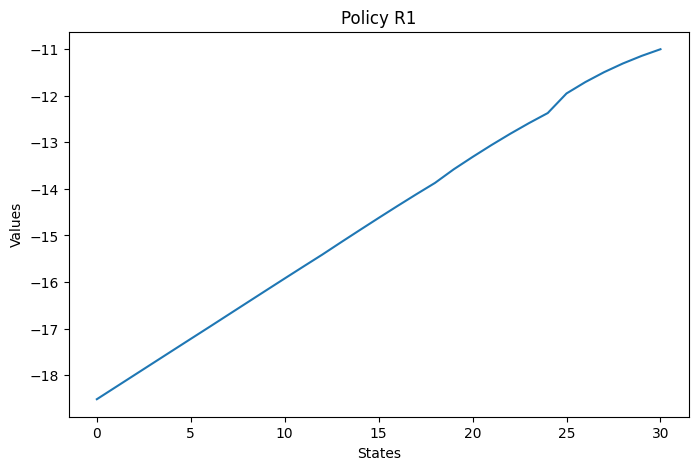

In [22]:
random.seed(10)

# Use length `MAX_STATE + 1` to include the terminal state
policy = np.array([1 for s in STATES])
values = np.zeros(MAX_STATES + 1)

while True:
    # Set delta to 0
    delta = 0
    
    # Update value function for each state
    for state in STATES:
        oldValue = values[state]

        action = policy[state]
        values[state] = R1_evalAction(state, action, values)

        delta = max(delta, abs(oldValue - values[state]))
    
    # Break if delta is small enough
    if delta < THETA:
        break

valuesR1 = values

plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesR1[:-1])

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy R1')
plt.show()

<p style="page-break-after:always;"></p>

###    “R2”: The player always rolls both dice.

Rewards/Transitions Probabilities Matrix

> There is multiple steps before having a proper Probabilities matrix

In [23]:
def create_dice_sum(row_names, column_names):
    rows = len(row_names)
    columns = len(column_names)
    data = [[row + column for column in column_names] for row in row_names]
    df = pd.DataFrame(data, index=row_names, columns=column_names)
    return df

row_names = np.array((1,2,3,4,5,6,6))
column_names = np.array((1,2,3,4,5,6,6))

R2_Dice_Outcome_Matrix = create_dice_sum(row_names, column_names)
R2_Dice_Outcome_Matrix

,1,2,3,4,5,6,6
1,2,3,4,5,6,7,7
2,3,4,5,6,7,8,8
3,4,5,6,7,8,9,9
4,5,6,7,8,9,10,10
5,6,7,8,9,10,11,11
6,7,8,9,10,11,12,12
6,7,8,9,10,11,12,12


> We first look at all combinations of the dices sum, knowing we can see the value 6 twice has much has the other.  The diagonal should be our _double_ cases when we are rewarded 10 CHF

In [24]:
def dice_probability(df, ascending=True):
    total_elements = df.size
    value_counts = df.stack().value_counts()
    probabilities = value_counts / total_elements
    
    # Create a dataframe with the probabilities
    probabilities_df = pd.DataFrame({'Total Probability': probabilities})
    probabilities_df.index.name = 'Dices Sum'
    probabilities_df = probabilities_df.sort_index(ascending=ascending)
    
    return probabilities_df

R2_Prob_Matrix = dice_probability(R2_Dice_Outcome_Matrix)
R2_Prob_Matrix
R2_Prob_Matrix["Double Probability"] = np.array([1/49,0,1/49,0,1/49,0,1/49,0,1/49,0,4/49])
R2_Prob_Matrix["Non-Double Probability"] = R2_Prob_Matrix["Total Probability"] - R2_Prob_Matrix["Double Probability"]
R2_Prob_Matrix


,Total Probability,Double Probability,Non-Double Probability
Dices Sum,,,
2,0.020408,0.020408,0.000000
3,0.040816,0.000000,0.040816
4,0.061224,0.020408,0.040816
5,0.081633,0.000000,0.081633
6,0.102041,0.020408,0.081633
7,0.163265,0.000000,0.163265
8,0.142857,0.020408,0.122449
9,0.122449,0.000000,0.122449
10,0.102041,0.020408,0.081633


> We can summarize the probabilities of each outcome for the Dice Sum. The total probability represents the likelihood of observing a particular sum in a dice roll. The double probability refers to the probability of obtaining that sum with the same values on both dice, while the non-double probability represents the complementary event.

For computation practices, we can also show the count of dice faces in a dataframe in 1 row

In [25]:
column_names = ['2D', '3', '4', '4D', '5', '6', '6D', '7', '8', '8D', '9', '10', '10D', '11', '12D']
dice_apparition = [1, 2, 2, 1, 4, 4, 1, 8, 6, 1, 6, 4, 1, 4, 4]

R2_Prob_Matrix_Simple2 = pd.DataFrame([dice_apparition],columns=column_names)
R2_Prob_Matrix_Simple2 = R2_Prob_Matrix_Simple2.reset_index(drop=True)
R2_Prob_Matrix_Simple2

,2D,3,4,4D,5,6,6D,7,8,8D,9,10,10D,11,12D
0,1,2,2,1,4,4,1,8,6,1,6,4,1,4,4


> Encoding the Dice Sum with "D" when the case of _double_ will help us when using the Reward matrix

... Dividing by the Total of Events (which is 49) to get the correct probabilities

In [26]:
R2_Prob_Matrix_Simple = R2_Prob_Matrix_Simple2/49
R2_Prob_Matrix_Simple

,2D,3,4,4D,5,6,6D,7,8,8D,9,10,10D,11,12D
0,0.020408,0.040816,0.040816,0.020408,0.081633,0.081633,0.020408,0.163265,0.122449,0.020408,0.122449,0.081633,0.020408,0.081633,0.081633


> Note: we can remove the event of sum to 1, since there is not possible case where 2 dices can sum to 1.

The State Probabilities are the Total Occurences of the Dices Face for a sum

In [27]:
column_names = np.arange(1,13)
dice_apparition2 = [0,1,2,3,4,5,8,7,6,5,4,4]

R2_Prob_State_Matrix_Simple2 = pd.DataFrame([dice_apparition2],columns=column_names)
R2_Prob_State_Matrix_Simple2 = R2_Prob_State_Matrix_Simple2.reset_index(drop=True)
R2_Prob_State_Matrix_Simple2

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1,2,3,4,5,8,7,6,5,4,4


... Divided by the Total of Events (which is 49) to get the correct probabilities

In [28]:
R2_Prob_State_Matrix_Simple = R2_Prob_State_Matrix_Simple2/49
R2_Prob_State_Matrix_Simple = R2_Prob_State_Matrix_Simple.iloc[:, 1:]
R2_Prob_State_Matrix_Simple

,2,3,4,5,6,7,8,9,10,11,12
0,0.020408,0.040816,0.061224,0.081633,0.102041,0.163265,0.142857,0.122449,0.102041,0.081633,0.081633


> Note: we can remove the event of sum to 1, since there is not possible case where 2 dices can sum to 1.

<p style="page-break-after:always;"></p>

Future State (S') Matrix

In [29]:
row_labels = list(range(MAX_STATES+1))
column_labels = list(range(2, 13))

R2_States_Matrix = pd.DataFrame(0, index=row_labels, columns=column_labels)

for row_label in row_labels:
    for column_label in column_labels:
        value = row_label + column_label
        R2_States_Matrix.loc[row_label, column_label] = 0 if value > 31 else value

R2_States_Matrix

,2,3,4,5,6,7,8,9,10,11,12
0,2,3,4,5,6,7,8,9,10,11,12
1,3,4,5,6,7,8,9,10,11,12,13
2,4,5,6,7,8,9,10,11,12,13,14
3,5,6,7,8,9,10,11,12,13,14,15
4,6,7,8,9,10,11,12,13,14,15,16
5,7,8,9,10,11,12,13,14,15,16,17
6,8,9,10,11,12,13,14,15,16,17,18
7,9,10,11,12,13,14,15,16,17,18,19
8,10,11,12,13,14,15,16,17,18,19,20
9,11,12,13,14,15,16,17,18,19,20,21


> We also set the future state to 0, if we reaching over 31.

<p style="page-break-after:always;"></p>

Rewards Matrix

In [30]:
temp_columns = np.arange(2,12+1)

temp_columns

# Create an empty array to store the modified values
modified_columns = []

# Iterate over the values in temp_columns
for value in temp_columns:
    modified_columns.append(value)
    if value % 2 == 0:
        modified_columns.append(str(value) + "D")

modified_columns = modified_columns[1:]
modified_columns = modified_columns
modified_columns.remove(12)
modified_columns

# Convert the modified_columns list to a NumPy array
modified_columns = np.array(modified_columns)

modified_columns

# Create a DataFrame with 31 rows and initialize all cells as 0
R2_Rewards_Matrix = pd.DataFrame(0, index=range(MAX_STATES+1), columns=modified_columns)

for column in R2_Rewards_Matrix.columns:
    if "D" in column:
        R2_Rewards_Matrix[column] = 8
    else:
        R2_Rewards_Matrix[column] = -2

for row_label in R2_Rewards_Matrix.index:
    for column in R2_Rewards_Matrix.columns:
        if "D" in column:
            column_value = int(column[:-1])
            if row_label + column_value >= 31:
                R2_Rewards_Matrix.loc[row_label, column] = -2
            elif row_label + column_value >= MAX_STATES + 1:
                R2_Rewards_Matrix.loc[row_label, column] = -2
            else:
                R2_Rewards_Matrix.loc[row_label, column] = 8
        else:
            column_value = int(column)
            if row_label + column_value >= 31:
                R2_Rewards_Matrix.loc[row_label, column] = -12

R2_Rewards_Matrix

,2D,3,4,4D,5,6,6D,7,8,8D,9,10,10D,11,12D
0,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
1,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
3,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
4,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
5,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
6,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
7,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
8,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8
9,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,-2,8,-2,8


In this Reward matrix, a gain of 8 is assigned in the case of a "double" outcome, while a loss of -2 is incurred if the score exceeds 31. Otherwise, a penalty of -2 (representing the cost of rolling two dice) is given, and a penalty of -12 is applied if the score overshoots.

<p style="page-break-after:always;"></p>

Evaluation Function

> We first implement a function to evaluate *V(s)*

In [31]:
def R2_evalAction(state, action, values):

    # Temporary add 0 elements to the values array, to not have different array size - Won't impact final calculus
    values_temp = np.append(values, np.zeros(12))
    
    # If we are at 31 States, we return 0
    if state == MAX_STATES:
        return 0
    
    # Action 2 is 2 Dices roll
    if action == 2: 
        eReward = (R2_Rewards_Matrix.iloc[state:state+1].reset_index(drop=True)*R2_Prob_Matrix_Simple).sum(axis=1)[0]
        eValue = GAMMA*((R2_Prob_State_Matrix_Simple*values_temp[state+2:state+13]).sum(axis=1))[0]
        V = eReward + eValue
        
        return V

Implement Iterative Policy Evaluation 

> And then we compute the recursive equation

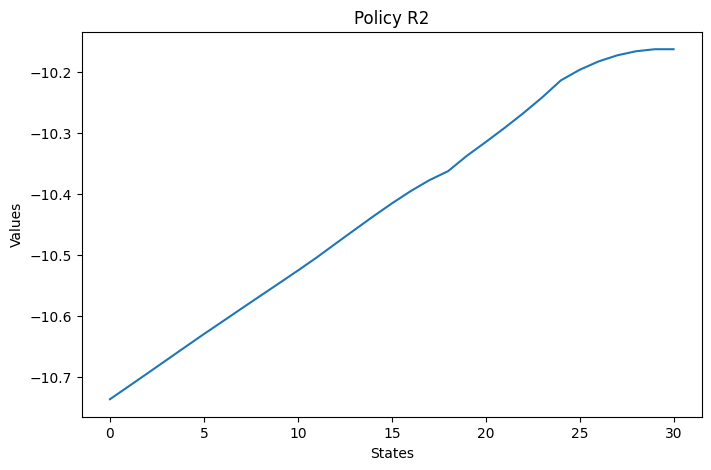

In [32]:
random.seed(10)

# Use length `MAX_STATE + 1` to include the terminal state
policy = np.array([2 for s in STATES])
values = np.zeros(MAX_STATES + 1)

while True:
    # Set delta to 0
    delta = 0
    
    # Update value function for each state
    for state in STATES:
        oldValue = values[state]

        action = policy[state]
        values[state] = R2_evalAction(state, action, values)

        delta = max(delta, abs(oldValue - values[state]))
    
    # Break if delta is small enough
    if delta < THETA:
        break

valuesR2 = values

plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], values[:-1])

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy R2')
plt.show()

<p style="page-break-after:always;"></p>

### “RR”: If the player’s score is strictly smaller than 20, they roll either one or two dice with equal probability. Otherwise, they choose one of the three bet-multiplicators uniformly at random

Rewards/Transitions Probabilities Matrix

> Future Dealer Score will have the same probablities as in the case of 1 dice

In [33]:
R3_Prob_Matrix = pd.DataFrame(np.tile(dice_probabilities, (MAX_STATES+1, 1)))
R3_Prob_Matrix.columns = range(25, 31)
round(R3_Prob_Matrix,4)

,25,26,27,28,29,30
0,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
1,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
2,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
3,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
4,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
5,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
6,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
7,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
8,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857
9,0.1429,0.1429,0.1429,0.1429,0.1429,0.2857


Future State (S') Matrix

> There is no future state except taht we should return the state 0, since betting leads to end of the round

<p style="page-break-after:always;"></p>

Rewards Matrix

In [34]:
row_labels = list(range(MAX_STATES+1))
column_labels = list(range(25, MAX_STATES))

R3_Rewards_Matrix = pd.DataFrame(0, index=row_labels, columns=column_labels)

for column_label in column_labels:
    R3_Rewards_Matrix[column_label] = R3_Rewards_Matrix.index - column_label

R3_Rewards_Matrix.loc[31] = 0

R3_Rewards_Matrix

,25,26,27,28,29,30
0,-25,-26,-27,-28,-29,-30
1,-24,-25,-26,-27,-28,-29
2,-23,-24,-25,-26,-27,-28
3,-22,-23,-24,-25,-26,-27
4,-21,-22,-23,-24,-25,-26
5,-20,-21,-22,-23,-24,-25
6,-19,-20,-21,-22,-23,-24
7,-18,-19,-20,-21,-22,-23
8,-17,-18,-19,-20,-21,-22
9,-16,-17,-18,-19,-20,-21


> We subtract our current score (player score) from the Dealer's roll of the dice. Later on, we will incorporate the multiplier.

<p style="page-break-after:always;"></p>

Evaluation Function

> We first implement a function to evaluate *V(s)*

In [35]:
def All_evalAction(state, action, values):
    
    # Temporary add 0 elements to the values array, to not have different array size limits - Won't impact final calculus
    values_temp = np.append(values, np.zeros(12))
   
    # If we are at 31 States, we return 0
    if state == MAX_STATES:
        return 0
    
    # Action 1 is 1 Dice roll
    if action == 1: 
        V = sum(np.array(R1_Prob_Matrix.loc[state])*(np.array(R1_Rewards_Matrix.loc[state]) + GAMMA*values_temp[state+1:state+7]))   
        
        return V

    # Action 2 is 2 Dices roll
    if action == 2: 
        eReward = (R2_Rewards_Matrix.iloc[state:state+1].reset_index(drop=True)*R2_Prob_Matrix_Simple).sum(axis=1)[0]
        eValue = GAMMA*((R2_Prob_State_Matrix_Simple*values_temp[state+2:state+13]).sum(axis=1))[0]
        V = eReward + eValue
    
        return V
    
    # Action 3 is Dealer Bet (Multiplicator 1)
    if action == 3: 
        V = sum(np.array(R3_Prob_Matrix.loc[state])*(np.array(R3_Rewards_Matrix.loc[state]))+ GAMMA*values_temp[31])*1
        
        return V
    
    # Action 4 is Dealer Bet (Multiplicator 2)
    if action == 4: 
        V = sum(np.array(R3_Prob_Matrix.loc[state])*(np.array(R3_Rewards_Matrix.loc[state]))+ GAMMA*values_temp[31])*2
        
        return V

    # Action 5 is Dealer Bet (Multiplicator 3)
    if action == 5: 
        V = sum(np.array(R3_Prob_Matrix.loc[state])*(np.array(R3_Rewards_Matrix.loc[state]))+ GAMMA*values_temp[31])*3

        return V 


> We combine all actions into this evaluation of the action function, as we are now integrating multiple actions into a policy.

<p style="page-break-after:always;"></p>

Implement Iterative Policy Evaluation 

> And then we compute the recursive equation

In [ ]:
# Use length `MAX_STATE + 1` to include the terminal state
#policy = np.zeros(MAX_STATES+1, dtype=int)

#for s in range(MAX_STATES+1):
#    if s < 20-1 :
#        policy[s] = np.random.choice([1, 2])
#    else:
#        policy[s] = np.random.randint(low=3,high=6, size=1)[0]

> This code was used to generate a random policy under RR

In [41]:
policy = [2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 3, 4, 4, 5, 3, 3, 5, 5, 4, 4, 5, 4, 3] # For reproducibility

values = np.zeros(MAX_STATES + 1)

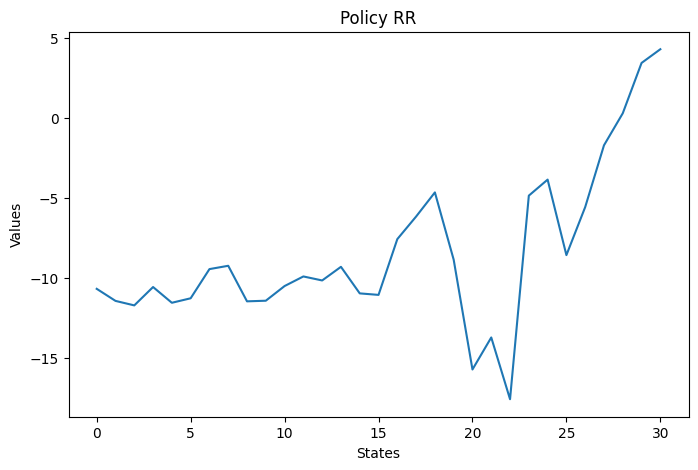

In [42]:
while True:
    # Set delta to 0
    delta = 0
    
    # Update value function for each state
    for state in STATES:
        oldValue = values[state]

        action = policy[state]
        values[state] = All_evalAction(state, action, values)

        delta = max(delta, abs(oldValue - values[state]))
    
    # Break if delta is small enough
    if delta < THETA:
        break

valuesRR = values

plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesRR[:-1])

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy RR')
plt.show()

<p style="page-break-after:always;"></p>

### All Policies Comparison

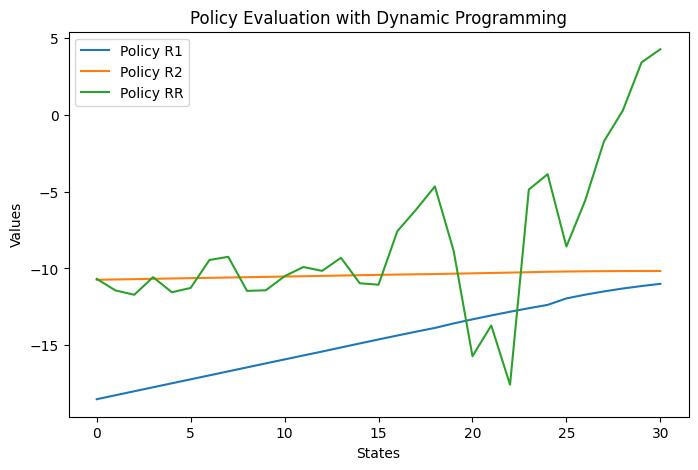

In [43]:
plt.figure(figsize=(8, 5))

# Plot multiple lines
plt.plot(STATES[:-1], valuesR1[:-1], label='Policy R1')
plt.plot(STATES[:-1], valuesR2[:-1], label='Policy R2')
plt.plot(STATES[:-1], valuesRR[:-1], label='Policy RR')

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy Evaluation with Dynamic Programming')

# Add a legend
plt.legend()

# Display the plot
plt.show()

> **Policy R1 (1 Dice roll)**: Indeed, Policy R1 appears to be the worst among the other policies, as it consistently results in an expected loss of -10 at the end of the round, coupled with the additional cost of -1 for each dice roll. The upward slope in the plot aligns with the intuition that starting at 0, there is a higher probability of rolling lower values, leading to a cumulative cost of -1 CHF per turn. The ideal scenario would be to roll higher values during the turn, as it would minimize the cumulative costs and result in a higher final score. This explains why the end states/scores have higher values, indicating more favorable outcomes in terms of expected rewards. Considering this information, it becomes evident that Policy R1 is not an optimal choice due to its consistently negative expected outcome and the additional cost incurred with each dice roll.

>  **Policy R2 (2 Dices roll)**: Policy R2, similar to R1, shows an upward slope in the plot. This is because R2 provides higher expected rewards starting from the initial state of 0. This is primarily due to two reasons. Firstly, R2 allows for higher dice sums, which result in completing the turn more quickly. This leads to lower overall costs compared to R1. Secondly, R2 benefits from a higher probability of rolling doubles when the dice sum is 6. Rolling doubles allows us to regain 10 CHF, compensating for any potential losses incurred during the turn. Consequently, these factors contribute to the higher expected rewards associated with Policy R2. The upward slope in the plot demonstrates the cumulative advantages of quicker turn completion, favorable probabilities, and the potential to recover any losses.

> **Policy RR (score is strictly smaller than 20, R1 and R2 with equal probability. Otherwise, bet-multiplicators uniformly at random)**: When following this policy, a distinct pattern emerges. The decision between R1 and R2 does not indicate a clear pattern of best or worst states. However, the threshold set at 20 for starting the dealer bet reveals a significant preference for avoiding that particular state. This is because at state 20, we are not given the choice to place a bet. Considering the probabilities of selecting a multiplier of 3, 2, or 1 (each with a 1/3 chance), this lack of choice can lead to substantial losses. Moreover, the dealer has a higher probability of obtaining a score of 30 due to the characteristics of their dice. Once we surpass state 20, the expected rewards and the value of the highest state begin to increase. Being at state 30 provides a greater chance of gaining an advantage over the dealer's dice roll. Therefore, the policy emphasizes the importance of reaching state 30 to maximize the expected rewards and improve the overall outcome compared to being in lower states.

<p style="page-break-after:always;"></p>

## 2.4. <a id='toc2_4_'></a>[Find the optimal policy using dynamic programming. Represent the action-value function under the optimal policy graphically. Explain the results and compare them to those of the previous task.](#toc0_)

### Policy Evaluation Function

In [44]:
def policyEvaluation(policy):
    # Initialize value function
    values = np.zeros(MAX_STATES + 1)

    while True:
        # Set delta to 0
        delta = 0
        
        # Update value function for each state
        for state in STATES:
            oldValue = values[state]

            action = policy[state]
            values[state] = All_evalAction(state, action, values)
        
            delta = max(delta, abs(oldValue - values[state]))
        
        # Break if delta is small enough
        if delta < THETA:
            break
    
    # Return the value function
    return values

### Policy Improvement Function

In [45]:
def policyImprovement(values):
    policy = []

    # Loop for each state
    for state in STATES:
        # If we are in a terminal state, do nothing (=0)
        if state == MAX_STATES:
            policy.append(0)
            continue
        
        # Initialize best action and its value
        bestAction = 0
        bestValue = float("-inf")

        # Loop for each action
        actions = range(1,6)
        for action in actions:
            # Compute the value of the action
            value = All_evalAction(state, action, values)
            
            # If the value is (significantly) better than the best value, update best value and best action
            if value - bestValue > 2*THETA: # (avoid noisy updates)
                bestValue = value
                bestAction = action
        
        # Append best action to policy
        policy.append(int(bestAction))
    
    # Return the policy
    return policy

<p style="page-break-after:always;"></p>

### Policy Implementation For Optimality

In [46]:
# Initialize values and policy
values = np.zeros(MAX_STATES + 1)
policy = [1 for s in STATES]

In [47]:
# Do policy iteration
while True:
    # Policy evaluation
    values = policyEvaluation(policy)

    # Policy improvement
    newPolicy = policyImprovement(values)

    # Check if policy has changed
    if newPolicy == policy:
        break

    # Update policy
    policy = newPolicy
    
valuesOPTIMAL = values
policyOPTIMAL = policy

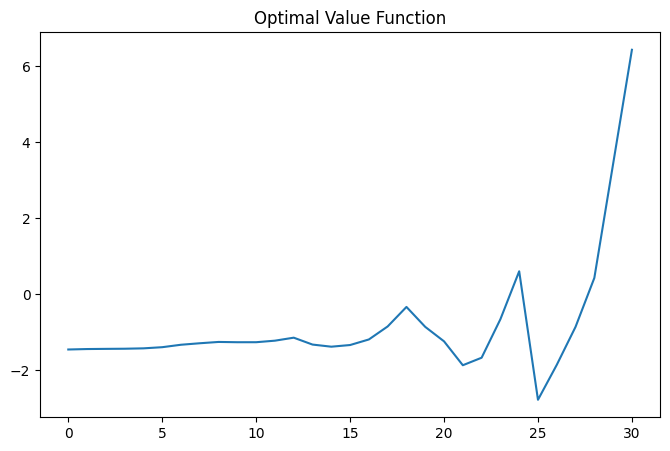

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesOPTIMAL[:-1])
plt.title('Optimal Value Function')
plt.show()

> For each state, the value function assigns a value that represents the desirability or quality of being in that particular position. This value helps in evaluating the goodness of a state and informs the decision-making process for future actions and subsequent states. From the provided plot, it appears that states 21 and 25 have lower expected rewards compared to other states. There are specific reasons for this observation.

> At state 21, there is a possibility of ending the turn without a dealer bet since rolling two dice may result in a sum of 10-12 more frequently (with a probability for 1 dice to get 6 with 2/7 probability). This outcome would lead to a loss of money without the opportunity to place a dealer bet.

> Similarly, at state 25, there is a high chance of rolling a 6 again, which would result in reaching a sum of 31 directly. This outcome would also lead to losing money without the chance to place a dealer bet.

> Considering these factors, it would be advisable to avoid states 21 and 25 due to their unfavorable expected rewards and the associated risks of losing money without the possibility of a dealer bet.

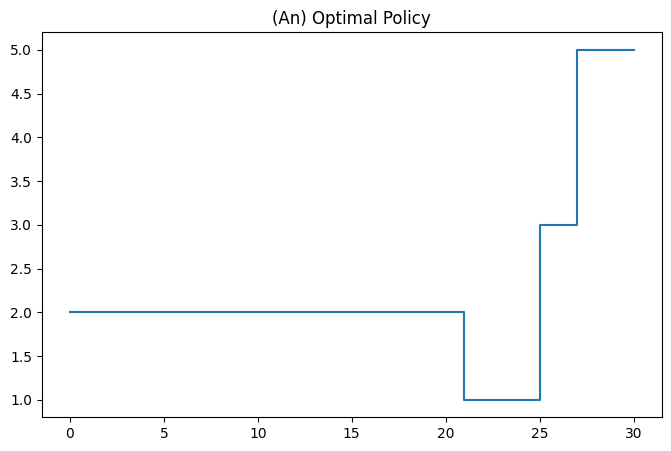

In [49]:
plt.figure(figsize=(8, 5))
plt.step(STATES[:-1], policyOPTIMAL[:-1])
plt.title('(An) Optimal Policy')
plt.show()

> With this plot, we can easily determine the optimal action to be undertaken under each state. The Y-axis represents the numbered actions, where each action corresponds to a specific strategy. For example, 1 Dice roll is represented by 1, 2 Dices roll by 2, Dealer bet with 1 multiplicator by 3, Dealer bet with 2 multiplicator by 4, and Dealer bet with 3 multiplicator by 5. By examining the plot, we can identify the recommended action for each state, aiding in the decision-making process.

In [50]:
# Create DataFrame with the row as a transposed column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_result = pd.DataFrame([policyOPTIMAL]).transpose()
result_optimal = df_result.T
result_optimal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,3,3,5,5,5,0


> Start by using 2 dice rolls (R2) until a score of 21 is reached. This choice is made to maximize expected rewards in the initial stages of the game.

> Once a score of 21 is attained, transition to using 1 dice roll (R1) until reaching a score between 22 and 25. The purpose of this switch is twofold: to minimize costs and mitigate the risk of overshooting and reaching a score of 31, which would result in a loss of 10 CHF

> When the score reaches 26, switch to the Dealer Bet action with a Multiplicator of 1 (action 3). This decision is based on the belief that the dealer has a higher probability of reaching a score of 30, reducing the likelihood of incurring losses.

> After reaching a score of 27, continue playing from 28 to 31 using the Dealer Bet action with a Multiplicator of 3 (action 5). This choice is made to maximize potential gains, as using a higher Multiplicator increases the expected rewards.

<p style="page-break-after:always;"></p>

# 3. <a id='toc3_'></a>[The Bonus](#toc0_)

Use the class you implemented in the first task for the following Monte Carlo simulation: estimate
the value of the initial state under each of the policies from the previous tasks (“R1”, “R2”, “RR”,
“Optimal”). Illustrate the results and compare them to the results of the previous tasks.

In [51]:
MAX_SCORE = 31

STATES = np.arange(MAX_SCORE + 1)

## 3.1. <a id='toc3_1_'></a>[“R1”: The player always rolls a single dice](#toc0_)

In [52]:
%%capture
gameR1Carlo = DiceGame()

def generateEpisode(game):
    game.reset()
    path = [0]
    rewards = [0]
    while True:
        state, reward = game.step(1)
        rewards.append(reward)
        if state >= 31:
            break
        path.append(state)

    return path, rewards

def monteCarloEpisode(game, values, alpha):
    path, rewards = generateEpisode(game)
    G = 0
    for t in reversed(range(len(path))):
        G += rewards[t+1]
        if not path[t] in path[0:t]:
            values[path[t]] += alpha * (G - values[path[t]])
            
    return 

# RUN MONTE CARLO to 10'000 EPISODES

N_EPISODES = 10000
ALPHA = 0.02
valuesR1Carlo = [0]*(MAX_SCORE+1)

for n in range(N_EPISODES):
    monteCarloEpisode(gameR1Carlo, valuesR1Carlo, ALPHA)    

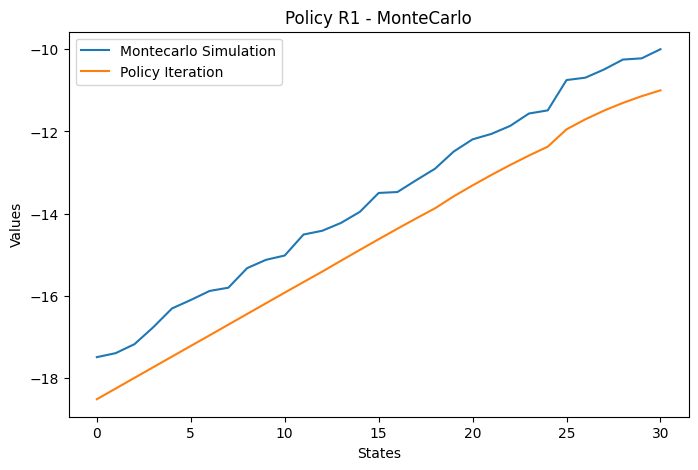

In [53]:
# Plot the estimated Value Function of this Policy
plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesR1Carlo[:-1],label='Montecarlo Simulation')
plt.plot(STATES[:-1], valuesR1[:-1], label='Policy Iteration')

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy R1 - MonteCarlo')

# Add a legend
plt.legend()

plt.show()

> Both value functions demonstrate a high degree of proximity, providing further confirmation of the trend observed in the Policy iteration estimation.

<p style="page-break-after:always;"></p>

## 3.2. <a id='toc3_2_'></a>[“R2”: The player always rolls both dice.](#toc0_)

In [54]:
%%capture
gameR2Carlo = DiceGame()

def generateEpisode2(game):
    game.reset()
    path = [0]
    rewards = [0]
    while True:
        state, reward = game.step(2)
        rewards.append(reward)
        if state >= 31:
            break
        path.append(state)

    return path, rewards

def monteCarloEpisode2(game, values, alpha):
    path, rewards = generateEpisode2(game)
    G = 0
    for t in reversed(range(len(path))):
        G += rewards[t+1]
        if not path[t] in path[0:t]:
            values[path[t]] += alpha * (G - values[path[t]])
            
    return 

# RUN MONTE CARLO to 10'000 EPISODES

N_EPISODES = 10000
ALPHA = 0.02
valuesR2Carlo = [0]*(MAX_SCORE+1)

for n in range(N_EPISODES):
    monteCarloEpisode2(gameR2Carlo, valuesR2Carlo, ALPHA)   


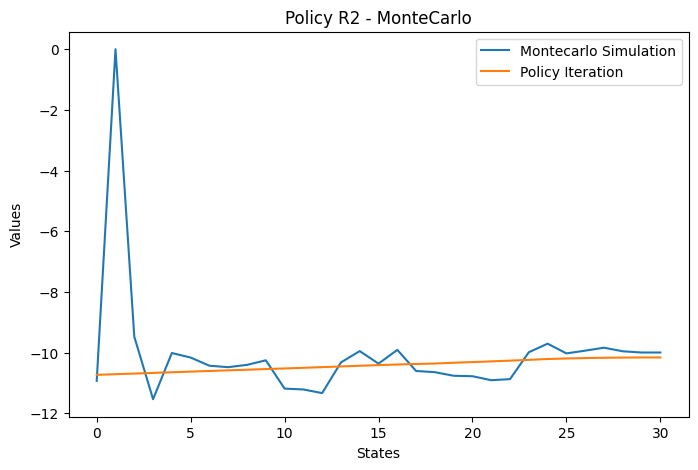

In [55]:
# Plot the estimated Value Function of this Policy
plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesR2Carlo[:-1],label='Montecarlo Simulation')
plt.plot(STATES[:-1], valuesR2[:-1], label='Policy Iteration')

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy R2 - MonteCarlo')

# Add a legend
plt.legend()

plt.show()

> The Monte Carlo method is also in close proximity to the Value function obtained from policy iteration. However, it is worth noting that there is a noticeable bump at state (1) in the Monte Carlo curve. This can be attributed to the fact that, in our simulation, this state is never actually entered.

<p style="page-break-after:always;"></p>

## 3.3. <a id='toc3_3_'></a>[“RR”: If the player’s score is strictly smaller than 20, they roll either one or two dice with equal probability. Otherwise, they choose one of the three bet-multiplicators uniformly at random](#toc0_)

In [56]:
%%capture
gameR3Carlo = DiceGame()

def generateEpisode3(game):
    game.reset()
    path = [0]
    rewards = [0]
    state = 0
    while True:
        if state < 20:
            state, reward = game.step(random.choice([1,2]))
            rewards.append(reward)
            if state >= 31:
                break
            path.append(state)

        if state >= 20 and state < 31:
            state, reward = game.step(random.choice([3,4,5]))
            rewards.append(reward)
            break    

    return path, rewards

def monteCarloEpisode3(game, values, alpha):
    path, rewards = generateEpisode3(game)
    G = 0
    for t in reversed(range(len(path))):
        G += rewards[t+1]
        if not path[t] in path[0:t]:
            values[path[t]] += alpha * (G - values[path[t]])
            
    return 

# RUN MONTE CARLO to 10'000 EPISODES

N_EPISODES = 10000
ALPHA = 0.02
valuesRRCarlo = [0]*(MAX_SCORE+1)

for n in range(N_EPISODES):
    monteCarloEpisode3(gameR3Carlo, valuesRRCarlo, ALPHA)  


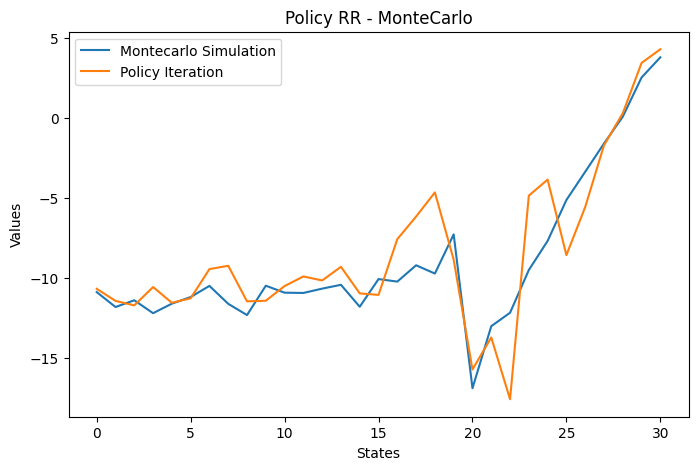

In [57]:
# Plot the estimated Value Function of this Policy
plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesRRCarlo[:-1],label='Montecarlo Simulation')
plt.plot(STATES[:-1], valuesRR[:-1], label='Policy Iteration')

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy RR - MonteCarlo')

# Add a legend
plt.legend()

plt.show()

> Both curves demonstrate a notable similarity, indicating a consistent trend between the two methods.

<p style="page-break-after:always;"></p>

## 3.4. <a id='toc3_4_'></a>["Optimal": Play R2 until 21, then R1 from 22 until 25 and Bet on the Dealer outcomes with Multiplicator of 1 from 26 to 27, Bet on the Dealer with Multiplicator of 3 from 28 until the end of the round.](#toc0_)

In [58]:
result_optimal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,3,3,5,5,5,0


In [59]:
%%capture
gameR4Carlo = DiceGame()

def generateEpisode4(game):
    game.reset()
    path = [0]
    rewards = [0]
    state = 0
    while True:
        if state < 22:
            state, reward = game.step(2)
            rewards.append(reward)
            if state >= 31:
                break
            path.append(state)

        if state >= 22 and state < 26:
            state, reward = game.step(1)
            rewards.append(reward)
            if state >= 31:
                break
            path.append(state)

        if state >= 26 and state < 28:
            state, reward = game.step(3)
            rewards.append(reward)
            break

        if state >= 28 and state < 31:
            state, reward = game.step(5)
            rewards.append(reward)
            break

    return path, rewards

def monteCarloEpisode4(game, values, alpha):
    path, rewards = generateEpisode4(game)
    G = 0
    for t in reversed(range(len(path))):
        G += rewards[t+1]
        if not path[t] in path[0:t]:
            values[path[t]] += alpha * (G - values[path[t]])
            
    return 

# RUN MONTE CARLO to 10'000 EPISODES

N_EPISODES = 1000
ALPHA = 0.02
valuesR4Carlo = [0]*(MAX_SCORE+1)

for n in range(N_EPISODES):
    monteCarloEpisode4(gameR4Carlo, valuesR4Carlo, ALPHA)  

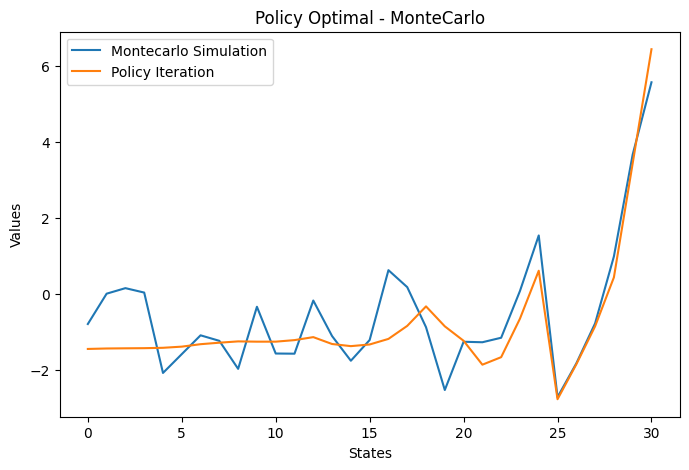

In [60]:
# Plot the estimated Value Function of this Policy
plt.figure(figsize=(8, 5))
plt.plot(STATES[:-1], valuesR4Carlo[:-1],label='Montecarlo Simulation')
plt.plot(STATES[:-1], valuesOPTIMAL[:-1], label='Policy Iteration')

# Set the x-axis and y-axis labels
plt.xlabel('States')
plt.ylabel('Values')

# Set the plot title
plt.title('Policy Optimal - MonteCarlo')

# Add a legend
plt.legend()

plt.show()

> In analyzing the plot, we can observe a striking similarity between both the Monte Carlo and policy iteration methods in terms of their estimation of the Value function. Both methods demonstrate a close convergence towards the boundaries of the action decisions.

> While there may be some minor differences, particularly in the form of slight noise observed at the beginning of the round in the Monte Carlo method, overall, the two methods align closely in their estimation of the Value function. This indicates that both approaches are effective in capturing the underlying dynamics and patterns of the problem.

> The convergence of both methods towards the boundaries of action decisions suggests that they are successfully capturing the optimal strategies and policies for maximizing expected rewards in different states. This similarity in achieving the same Value function estimation highlights the robustness and reliability of both the Monte Carlo and policy iteration methods in tackling the problem at hand.

---

<div style="text-align: center;">
    <h3>END OF PROJECT</h3>
</div>